# 1 Methods for Generating Random Variables

## Generating Random Variables

### Linear Congruential Generator

We can use a linear congruential generator (线性同余发生器) to generate random numbers. The linear congruential generator is defined by the recurrence relation

$$x_{n+1} = (ax_n + c) \mod m$$

where $a$, $c$, and $m$ are integers. The modulus $m$ is usually a large prime number (i.e. $2^{31}-1$ is a prime). The seed $x_0$ is an integer between 0 and $m-1$.


In [54]:
from time import time
class linear_congruential_generator():
    a = 1103515245
    m = 2147483647
    c = 1234567890
    seed_ = 1 # int(time() * 1000) % m
    @classmethod
    def seed(cls, seed__):
        cls.seed_ = seed__

    @classmethod
    def random(cls):
        cls.seed_ = (cls.a * cls.seed_ + cls.c) % cls.m
        return cls.seed_ / cls.m

for _ in range(10):
    print(linear_congruential_generator.random())

0.08875480298360568
0.734270822598725
0.2712740382511514
0.35774912515550344
0.06940153058124778
0.5976311031717952
0.8111343182675235
0.5257845989082868
0.05639533654618791
0.20051448009932157


### Inverse Transform Method

If $U\sim U(0,1)$ is standard uniform, then $F^{-1}(U)$ is a random variable with distribution function $F$. This is called the inverse transform method. Here $F^{-1}(u) = \inf\{x: F(x)\geqslant u\}$.

Mathematically,

$$\mathbb P(F^{-1}(U)\leqslant  x) = \mathbb P(U\leqslant  F(x)) = F(x)$$

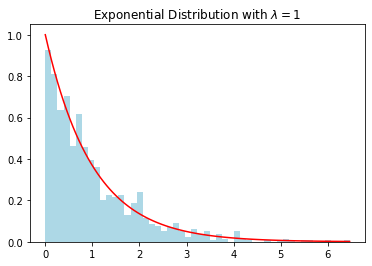

In [83]:
import numpy as np
def inverse_transform(invF, u):
    return invF(u)

def exponential_random_variable(lam):
    # y = F(x) = 1 - exp(-lam * x)
    # x = log(1 - y) / -lam
    return inverse_transform(lambda u: -1 / lam * np.log(1 - u), linear_congruential_generator.random())

# generate 1000 random variables
lam = 1
linear_congruential_generator.seed(1)
random_variables = np.array([exponential_random_variable(lam) for _ in range(1000)])

# plot the histogram and compare with the theoretical pdf
from matplotlib import pyplot as plt
plt.hist(random_variables, density=True, bins=50, color='lightblue')
x = np.linspace(0, random_variables.max(), 100)
plt.plot(x, lam * np.exp(-lam * x), color='red')
plt.title('Exponential Distribution with $\\lambda = {}$'.format(lam))
plt.show()

However, sometimes it is difficult to compute $F$ and $F^{-1}$ (e.g. normal distribution) for the inverse transform method. In this case, we can use the following algorithm:


### Acceptance-Rejection Method

If for random variable $X$ with density $f$, we can find another random variable $Y$ with density $g$ such that $f(x)\leqslant cg(x)$ for some constant $c$, then we can generate $X$ by the following steps:

1. Generate a particular value $y$ from P.D.F. $g$.
2. Generate a uniform random variable $u$ on $(0,1)$.
3. If $u\leqslant \frac{f(y)}{cg(y)}$, then output $x=y$. Otherwise, go back to step 1 until it holds.

This is called the acceptance-rejection method (舍选法).

**Proof** Given arbitrary $x_0$, we have three cases in each loop: (i) accept $x\leqslant x_0$, (ii) accept $x>x_0$, (iii) $y$ is rejected. Repeating the loop until (iii) does not happen, we have the relation that:

$$\frac{\mathbb P(\text{Finally accept } x\leqslant x_0)}{\mathbb P(\text{Finally accept } x> x_0)}=\frac{\mathbb P(\text{Case (i)})}{\mathbb P(\text{Case (ii)})}$$

While in a single loop, we have

$$\mathbb P(\text{Case (i)}) = \mathbb P(y\leqslant  x_0, \ u \leqslant  \frac{f(y)}{cg(y)}) 
=\int_{-\infty}^{x_0} \frac{f(y)}{cg(y)}\cdot g(y)dy=\frac1c\mathbb P(X\leqslant x_0).$$

Similarly, $\mathbb P(\text{Case (ii)}) =\frac1c \mathbb P(X> x_0)$.

Therefore, ${\mathbb P(\text{Finally accept } x\leqslant x_0)} = \mathbb P(X\leqslant x_0)$ as desired.

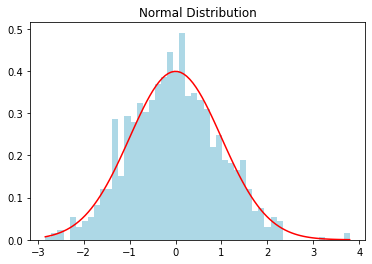

In [84]:
def acceptance_rejection(f, g, invG, c):
    while True:
        y = inverse_transform(invG, linear_congruential_generator.random())
        u = linear_congruential_generator.random()
        if u < f(y) / (c * g(y)):
            return y

def normal_random_variable():
    f = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
    g = lambda x: 1 / np.pi / (1 + x**2) # something easy to compute G and invG
    # G = lambda x: np.arctan(x) / np.pi + 0.5
    invG = lambda u: np.tan(np.pi * (u - 0.5))

    # f <= 1.6 * g
    return acceptance_rejection(f, g, invG, 1.6)

# generate 1000 random variables
linear_congruential_generator.seed(1)
random_variables = np.array([normal_random_variable() for _ in range(1000)])

# plot the histogram and compare with the theoretical pdf
from matplotlib import pyplot as plt
plt.hist(random_variables, density=True, bins=50, color='lightblue')
x = np.linspace(random_variables.min(), random_variables.max(), 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), color='red')
plt.title('Normal Distribution')
plt.show()

## Transformations

Some random variables can be generated by applying transformations.

### Transformations

These are some common transformations:

1. If $Z\sim N(0,1)$, then $X=\mu+\sigma Z\sim N(\mu,\sigma^2)$.
2. If $Z\sim N(0,1)$, then $Z^2\sim \chi^2(1)$.
3. If $U\sim \chi^2(m)$ and $V\sim \chi^2(n)$ are independent, then $F = \frac{U/m}{V/n}\sim F(m,n)$.
4. If $Z\sim N(0,1)$ and $U\sim \chi^2(m)$ are independent, then $T = \frac{Z}{\sqrt{U/m}}\sim t(m)$.
5. (Box Muller) If $U,V\sim U(0,1)$ are independent, then $Z_1=\sqrt{-2\log U}\cos(2\pi V)$ and $Z_2=\sqrt{-2\log U}\sin(2\pi V)$ are independent $N(0,1)$.

The first four are well-known from definition. We will prove the last one.

**Proof** Attempting to use the Cramer-Wold device, for arbitrary $a,b\in\mathbb R$, the characteristic function of $aZ_1+bZ_2$ is

$$\begin{aligned}\psi_{aZ_1+bZ_2}(t)& =\mathbb E(e^{i(aZ_1+bZ_2)t}) = \mathbb E(e^{i(a\sqrt{-2\log U}\cos(2\pi V)+b\sqrt{-2\log U}\sin(2\pi V))t})
\\ &= \int_0^1\int_0^1 e^{i(a\sqrt{-2\log u}\cos(2\pi v)+b\sqrt{-2\log u}\sin(2\pi v))t}dvdu 
\\ &= \int_0^1\int_0^1 e^{it\sqrt{-2(a^2+b^2)\log u}\sin(2\pi v)}dvdu.\end{aligned}$$

Next we denote $w = t\sqrt{a^2+b^2}$, and we take the transformation $u = e^{-\frac 12 r^2}$, $v = \frac{1}{2\pi }\theta$, then

$$\begin{aligned}\psi_{aZ_1+bZ_2}(t)& =  \frac{1}{2\pi}\int_0^{\infty}\int_0^{2\pi}r e^{iwr\sin\theta - \frac12r^2} d\theta  dr
\\ &= \frac{1}{2\pi}\int_0^\infty\int_0^\infty  e^{iwy - \frac12(x^2+y^2)}dxdy
\\ &= \frac{1}{\sqrt{2\pi}}\int_0^\infty e^{iwy - \frac12 y^2}dy=\psi_{N(0,1)}(w) = e^{-\frac12 t^2(a^2+b^2)}
.\end{aligned}$$

<!-- Note that for $w\in \mathbb R$,

$$\begin{aligned}\int_0^1 e^{iw\sqrt{-2\ln x}}dx & \stackrel{x=e^{-t^2/2}}{=\!=\!=\!=\!=\!=}\int_{0}^\infty te^{iwt-\frac12 t^2}dt 
 =e^{-\frac12 w^2}\int_{-wi}^{-wi+\infty} (t+wi)e^{-\frac12 t^2}dt \\ &
 = 1-iwe^{-\frac12 w^2}\left[\sqrt{\frac{\pi}{2}}+\int_0^{-wi}e^{-\frac12 t^2}dt\right]
\end{aligned}$$ -->

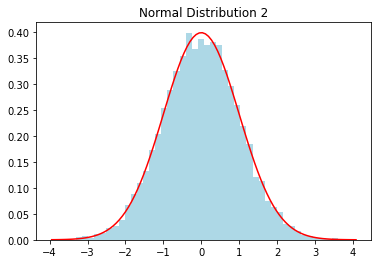

In [87]:
def normal_random_variable2():
    u, v = linear_congruential_generator.random(), linear_congruential_generator.random()
    return np.sqrt(-2 * np.log(u)) * np.cos(2 * np.pi * v)

# generate 10000 random variables
linear_congruential_generator.seed(1)
random_variables = np.array([normal_random_variable2() for _ in range(10000)])

# plot the histogram and compare with the theoretical pdf
from matplotlib import pyplot as plt
plt.hist(random_variables, density=True, bins=50, color='lightblue')
x = np.linspace(random_variables.min(), random_variables.max(), 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), color='red')
plt.title('Normal Distribution 2')
plt.show()

### Summation

Some random variables are the sum of multiple independent random variables. Gamma distribution $\Gamma(\alpha,\beta)$ has following P.D.F.:

$$f(x) = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}.$$

Gamma distribution is additive: if $X\sim \Gamma(\alpha_1,\beta)$ and $Y\sim \Gamma(\alpha_2,\beta)$ are independent, then $X+Y\sim \Gamma(\alpha_1+\alpha_2,\beta)$.

Also, the exponential distribution is $\text{Exp}(\lambda) = \Gamma (1,\beta)$, and the chi-squared distribution is $\chi^2(n) = \Gamma(\frac n2,\frac12)$.

### Mixture

If we have the distribution of $X|Y$ and $Y$, then we call $X$ a mixture of $X|Y$ and $Y$. 

A special case is when $Y$ is discrete. Then we have

$$\mathbb P(X) = \sum_{y\in Y} \mathbb P(X|Y=y)\mathbb P(Y=y).$$

For example, the Gaussian mixture model is a mixture of normal distributions.



## Generating Random Vectors

Data points can be high dimensional, in $\mathbb R^d$. 

### Multivariate Normal Distribution

For multivariate normal distribution $N(\mu,\Sigma)$, it can be generated by applying transformation on the standard multivariate normal $N(0,I)$.

We can find some matrix $A$ such that $AA^T=\Sigma$, then $Ax+\mu$ will be $N(\mu,\Sigma)$ if $x$ is $N(0,I)$.

Common ways to find $A$ include Cholesky decomposition, eigenvalue decomposition and singular value decomposition.

In [2]:
from time import time
import numpy as np
def cov(A):
    return A @ A.T

def multivariate_normal_distribution(n, mu, Sigma, method='cholesky'):
    """
    Generate n samples from a multivariate normal distribution with mean mu and covariance matrix Sigma.
    Method should be one of ['cholesky', 'eigen', 'svd', 'eigh']
    """
    if method == 'cholesky':
        A = np.linalg.cholesky(Sigma)
    elif method == 'eigen':
        eigs = np.linalg.eig(Sigma)
        A = eigs[1] * np.sqrt(eigs[0]).reshape(1, -1)
    elif method == 'svd':
        eigs = np.linalg.svd(Sigma)
        A = eigs[0] * np.sqrt(eigs[1]).reshape(1, -1)
    elif method == 'eigh':
        eigs = np.linalg.eigh(Sigma)
        A = eigs[1] * np.sqrt(eigs[0]).reshape(1, -1)
        
    z = np.random.randn(mu.shape[0], n)
    return mu.reshape(-1, 1) + A @ z

def time_test(n = 1000, d = 50, times = 200, seed = 100, method = 'cholesky'):
    np.random.seed(seed)
    mu = np.random.randn(d)
    start_time = time()
    for _ in range(times):
        Sigma = cov(np.random.randn(d,d))
        gen = multivariate_normal_distribution(n, mu, Sigma)
    end_time = time()
    return end_time - start_time

for method in ['cholesky', 'eigen   ', 'svd     ', 'eigh    ']:
    # very slight difference?
    print(f"Method: {method}, time: {time_test(method=method.strip())}")

Method: cholesky, time: 1.2295506000518799
Method: eigen   , time: 1.015258550643921
Method: svd     , time: 0.9494452476501465
Method: eigh    , time: 0.9686329364776611


### Wishart Distribution

If $X\in\mathbb R^{n\times d}$ is a random matrix where each row is a sample from $N(0,\Sigma)$, then we say $X^TX\in \mathbb R^{d\times d}$ is a random matrix following [Wishart distribution](https://handwiki.org/wiki/Wishart_distribution) $W_d(n, \Sigma)$.

In particular when $d = 1$, $W_1(n, \sigma^2) = \sigma^2\chi^2(n)$.


However, it is slow to compute $X^TX\in\mathbb R^{d\times d}$ when $n$ is large because we need to generate $X$ first, even though the size of $X^TX$ does not depend on $n$.

#### Bartlett Decomposition

Bartlett decomposition is a faster way to generate Wishart distribution $W_d(n, \Sigma)$.

Define $L\in\mathbb R^{d\times d}$ by the following lower triangular matrix:

$$L = \left[\begin{matrix}\chi^2(n) & 0 & 0 & \cdots & 0\\ N(0,1) & \chi^2(n-1) & 0 &  \cdots & 0\\ N(0,1) & N(0,1) & \chi^2(n-2) & \cdots & 0 \\  \vdots & \vdots & \vdots & \ddots & \vdots\\ N(0,1) & N(0,1) & N(0,1) & \cdots & \chi^2(n-d+1)\end{matrix}\right]$$

Here all entries are independent. Then $LL^T$ is a Wishart distribution $W_d(n, I_d)$.

In [ ]:
import numpy as np
def wishart(n, Sigma):
    d = Sigma.shape[0]
    A = np.linalg.cholesky(Sigma)
    L = np.tril(np.random.randn(d, d))
    L.flat[::d+1] = np.random.chisquare(n - np.arange(d))
    return A @ L @ L.T @ A.T

### Uniform on a Sphere

If $X_1,\dotsc,X_d$ are independent $N(0,1)$, then $\frac{X}{\Vert X\Vert}$ is uniformly distributed on the unit sphere where $X = [X_1,\dotsc,X_d]^T$.


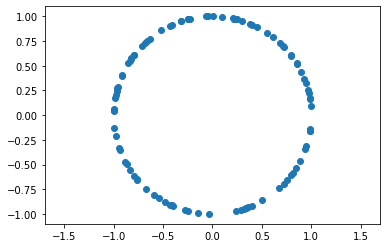

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def uniform_on_sphere(n, d):
    z = np.random.randn(n, d)
    z /= np.linalg.norm(z, axis=1, keepdims=True)
    return z

np.random.seed(0)
z = uniform_on_sphere(n = 100, d = 2)
[plt.scatter(z[:,0], z[:,1]), plt.axis('equal')]
plt.show()